<a href="https://colab.research.google.com/github/Nevermetyou65/GANs-Exercises/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 28*28*1
z_dim = 100 # size of noise vector

In [ ]:
def build_generator(img_shape, z_dim):
    
    model = Sequential(name='generator')
    model.add(Dense(units=128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(units=28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))

    return model # รับ noise แล้ว gen image ปลอมออกไป

In [ ]:
def build_discriminator(img_shape):
    
    model = Sequential(name='discriminator')
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(units=128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential(name='GAN')
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# instantiate discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# instantiate generator
generator = build_generator(img_shape, z_dim)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
discriminator.trainable = False

In [ ]:
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())
gan.summary()   

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28, 1)         114064    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


You're exactly right . By setting trainable=False after the discriminator has been compiled the discriminator is still trained during discriminator.train_on_batch but since it's set to non-trainable before the combined model is compiled it's not trained during combined.train_on_batch.

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train / 127.5) - 1.0 # rescale -> [-1, 1] จะได้สอดคล้องกับ value ใน output ของ generator
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # ------------ train discriminator -------------------------
        idx =  np.random.randint(0, X_train.shape[0], size=batch_size)
        imgs = X_train[idx] # real images (batch_size, 28,28,1)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z) # output (batch_size, 28, 28, 1)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = np.add(d_loss_real, d_loss_fake)/2
        # ตอน trian discriminator ใช้แค่ตัวมันเอง แล้วรับ input จาก 2 ทาง
        # ----------------------------------------------------------

        # ------------ train generator -----------------------------
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real) # เข้าใจว่าใส่ real ไปเพราะ ถ้า discriminator ดีจริงต้อง predict 
        # เป็น 0 ให้หมดแล้ว loss จะเยอะมากเพื่อมา update generator แต่พอ generator เก่งพอแล้ว ทำให้ discriminator ทายเป้น 1 ทั้งหมด
        # loss ก็จะน้อย ก็คือพอแล้วไม่ต้อง update อะไรมาก

        # ตอน train generator ต้องใช้ทั้งสองตัวเลย เพราะต้องให้ discirminator เป็นคน predict
        # ----------------------------------------------------------
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy) 
            iteration_checkpoints.append(iteration+1)
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration+1, d_loss, 100.0*accuracy, g_loss))
        
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, size=(image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z) # output น่าจะเป้น (16, 28, 28, 1)
    gen_imgs = (0.5*gen_imgs) * 0.5

    fig, axes = plt.subplots(image_grid_rows, image_grid_columns,
                             figsize=(4, 4),
                             sharey=True,
                             sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axes[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axes[i, j].axis('off')
            cnt += 1

1000 [D loss: 0.145673, acc.: 98.05%] [G loss: 3.065373]
2000 [D loss: 0.139252, acc.: 91.80%] [G loss: 4.760772]
3000 [D loss: 0.116318, acc.: 95.31%] [G loss: 5.804353]
4000 [D loss: 0.170946, acc.: 92.97%] [G loss: 4.733229]
5000 [D loss: 0.323909, acc.: 87.89%] [G loss: 4.107184]
6000 [D loss: 0.396619, acc.: 82.42%] [G loss: 3.413940]
7000 [D loss: 0.378104, acc.: 83.98%] [G loss: 3.043535]
8000 [D loss: 0.559244, acc.: 80.08%] [G loss: 3.323745]
9000 [D loss: 0.355049, acc.: 85.16%] [G loss: 3.130651]
10000 [D loss: 0.584455, acc.: 74.61%] [G loss: 3.134364]
11000 [D loss: 0.388597, acc.: 83.98%] [G loss: 3.143925]
12000 [D loss: 0.281861, acc.: 87.11%] [G loss: 3.237762]
13000 [D loss: 0.421084, acc.: 80.08%] [G loss: 2.201516]
14000 [D loss: 0.353022, acc.: 82.42%] [G loss: 2.609414]
15000 [D loss: 0.365541, acc.: 82.42%] [G loss: 3.153134]
16000 [D loss: 0.369219, acc.: 84.77%] [G loss: 2.817098]
17000 [D loss: 0.501834, acc.: 79.69%] [G loss: 2.950924]
18000 [D loss: 0.382934

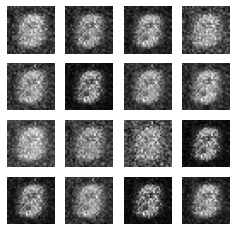

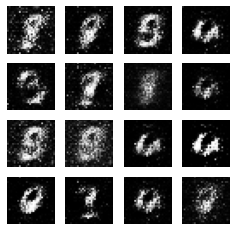

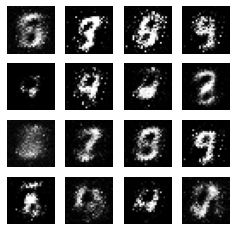

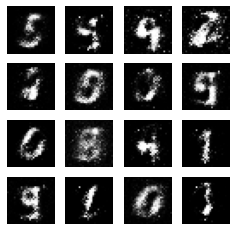

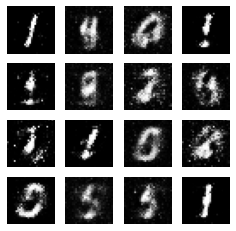

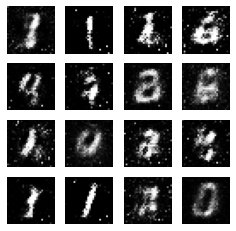

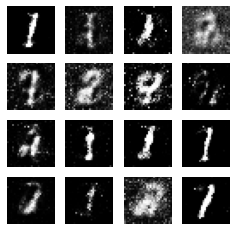

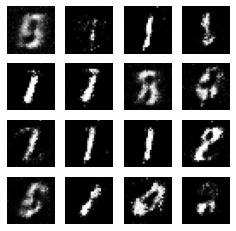

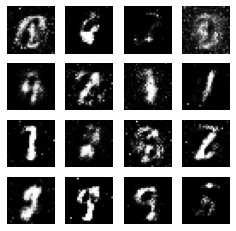

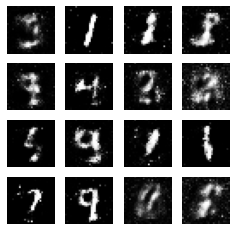

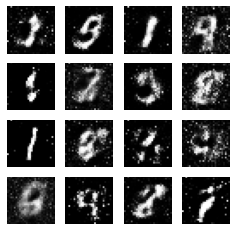

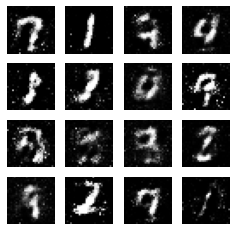

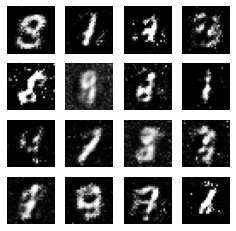

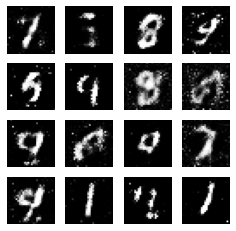

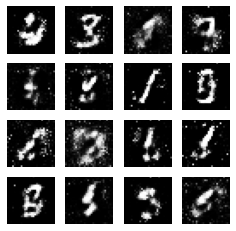

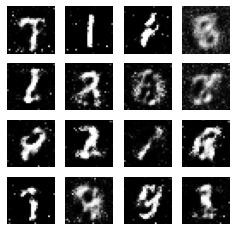

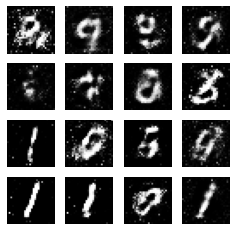

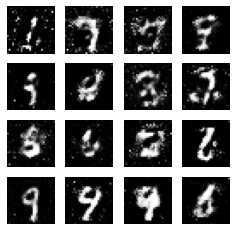

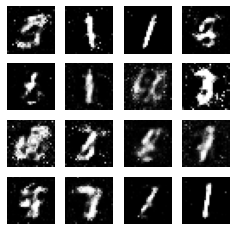

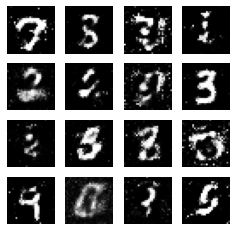

In [ ]:
# training
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)